# FORECASTING THE NEXT WEEK NUMBER OF ORDER

## LIBRARY

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
import math
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf


## OPEN FILE

In [49]:
# Load the dataset
def open_file():
    file_path = 'Input_data_timeseries (version 1).xlsx'  # Replace with your file's path
    data = pd.read_excel(file_path, sheet_name='db')
    #display(data)
    return data

## PARSE THE DATE

In [50]:
def parse_date(data):
    data['ORDER DATE'] = pd.to_datetime(data['ORDER DATE'])
    data = data.sort_values('ORDER DATE').set_index('ORDER DATE')
    return data

## SPLIT DATA

In [51]:
def split_data(data):
    # Define proportions
    #train_size = int(len(route_data) * 0.6)
    #val_size = int(len(route_data) * 0.2)
    train_size = int(len(data) * 0.8)

    # Split the data
    train = data.iloc[:train_size] #60%
    #val = route_data.iloc[train_size:train_size + val_size] #20%
    #test = route_data.iloc[train_size + val_size:] #20%
    test = data.iloc[train_size:]

    #print(f"Training size: {len(train)}, Validation size: {len(val)}, Test size: {len(test)}")
    #print(f"Training size: {len(train)}, Test size: {len(test)}")
    return train, test

## ACF

In [52]:
def acf(data):
    # Plot ACF
    plot_acf(data['NUMBER OF ACTUAL ORDERS'], lags=14)
    plt.title('Autocorrelation Function (ACF)')
    plt.show()

## AUTO_ARIMA

In [53]:
def best_parameter(train):
    
    arima_model = auto_arima(train, 
                         start_p =0, start_q=0, d=None, max_p = 5, max_d=2, max_q = 5, 
                         start_P = 1, D = None, start_Q = 1, max_P=2, max_D = 1, max_Q=2,
                         seasonal = True, m = 7,
                         information_criterion = 'aic', n_jobs = 1,
                         suppress_warning = True,
                         error_action = 'ignore',
                         trace = True,
                         stepwiese=True)
    
    return arima_model

## CREATE THE MODEL

In [54]:
def create_model(train, p, d, q, P, D, Q, S):
    model = SARIMAX(train, order=(p,d,q), seasonal_order=(P,D,Q,S))
    SARIMAX_model = model.fit()
    return SARIMAX_model

## PREDICTION

In [55]:
def prediction(SARIMAX_model, train, test, route):
    
    SARIMAX_prediction = SARIMAX_model.get_prediction(start=test.index[0], end=test.index[-1])
    df_sarimax = SARIMAX_prediction.summary_frame()
    
    plt.figure(figsize=(20, 10))
    plt.title(f'ROUTE:{route}') # attenzione MODIFicare quando farà loop sulle tratte!!! 
    plt.plot(train, color='green',label='Training data')
    plt.plot(test, color='black', label='Testing data')
    plt.plot(df_sarimax['mean'], color='red', label='Predictions Auto SARIMA')
    plt.fill_between(df_sarimax.index, df_sarimax['mean_ci_lower'], df_sarimax['mean_ci_upper'], alpha=.1, color='crimson', label='95% CI')
    plt.xlabel('Year')
    plt.ylabel('Number of orders')

    plt.legend()
    plt.show()

# MAIN

,ROUTE,ORDER DATE,NUMBER OF ACTUAL ORDERS
0,BELGIUM__BELGIUM,2022-12-13,4
1,BELGIUM__BELGIUM,2022-12-13,1
2,BELGIUM__BELGIUM,2022-12-13,7
3,BELGIUM__BELGIUM,2022-12-13,19
4,BELGIUM__BELGIUM,2022-12-13,22
...,...,...,...
170027,SCANDINAVIA__ITALY_SOUTH,2022-01-01,0
170028,SCANDINAVIA__ITALY_SOUTH,2022-01-01,0
170029,SCANDINAVIA__ITALY_SOUTH,2022-01-01,0
170030,NaN,NaT,772574


,ROUTE,NUMBER OF ACTUAL ORDERS
ORDER DATE,,
2022-01-01,SCANDINAVIA__ITALY_SOUTH,0
2022-01-01,EAST_NORTH__EAST_NORTH,0
2022-01-01,EAST_NORTH__ITALY_NORTH_EAST_CENTER,0
2022-01-01,EAST_NORTH__ITALY_NORTH_EAST_CENTER,0
2022-01-01,EAST_NORTH__ITALY_NORTH_EAST_CENTER,0
...,...,...
2022-12-13,ITALY_NORTH_WEST__BELGIUM,3
2022-12-13,ITALY_NORTH_WEST__GERMANY_NORTH,0
2022-12-13,BELGIUM__BELGIUM,4


ROUTE: SCANDINAVIA__ITALY_SOUTH


,NUMBER OF ACTUAL ORDERS
ORDER DATE,
2022-01-01,0
2022-01-02,0
2022-01-03,11
2022-01-04,12
2022-01-05,14
...,...
2022-12-09,15
2022-12-10,0
2022-12-11,0


TRAIN data:


,NUMBER OF ACTUAL ORDERS
ORDER DATE,
2022-01-01,0
2022-01-02,0
2022-01-03,11
2022-01-04,12
2022-01-05,14
...,...
2022-09-30,13
2022-10-01,0
2022-10-02,1


TEST data:


,NUMBER OF ACTUAL ORDERS
ORDER DATE,
2022-10-05,21
2022-10-06,13
2022-10-07,18
2022-10-08,0
2022-10-09,0
...,...
2022-12-09,15
2022-12-10,0
2022-12-11,0


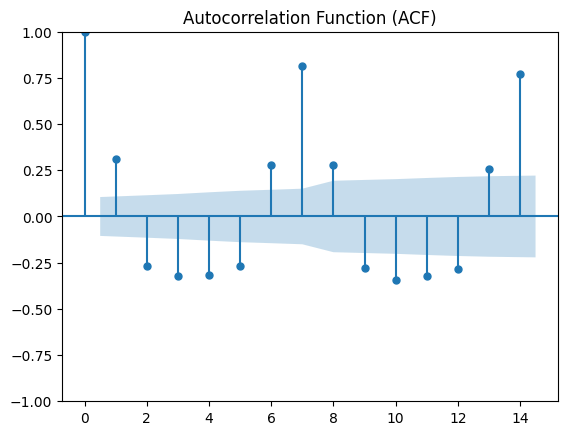

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=1969.664, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=1694.343, Time=0.53 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=1967.676, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=1970.745, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=1652.048, Time=0.63 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=0.75 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=1698.645, Time=0.15 sec
 ARIMA(2,1,0)(2,0,0)[7] intercept   : AIC=1628.653, Time=0.37 sec
 ARIMA(2,1,0)(1,0,0)[7] intercept   : AIC=1667.012, Time=0.39 sec
 ARIMA(2,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=1.03 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : AIC=1563.492, Time=0.51 sec
 ARIMA(2,1,0)(0,0,1)[7] intercept   : AIC=1815.297, Time=0

c:\Users\elped\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\elped\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:           NUMBER OF ACTUAL ORDERS   No. Observations:                  277
Model:             SARIMAX(4, 1, 1)x(1, 0, 1, 7)   Log Likelihood                -747.766
Date:                           Fri, 29 Nov 2024   AIC                           1511.532
Time:                                   19:57:22   BIC                           1540.495
Sample:                               01-01-2022   HQIC                          1523.154
                                    - 10-04-2022                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2165      0.063      3.458      0.001       0.094       0.339
ar.L2          0.0519      0.094      0.549

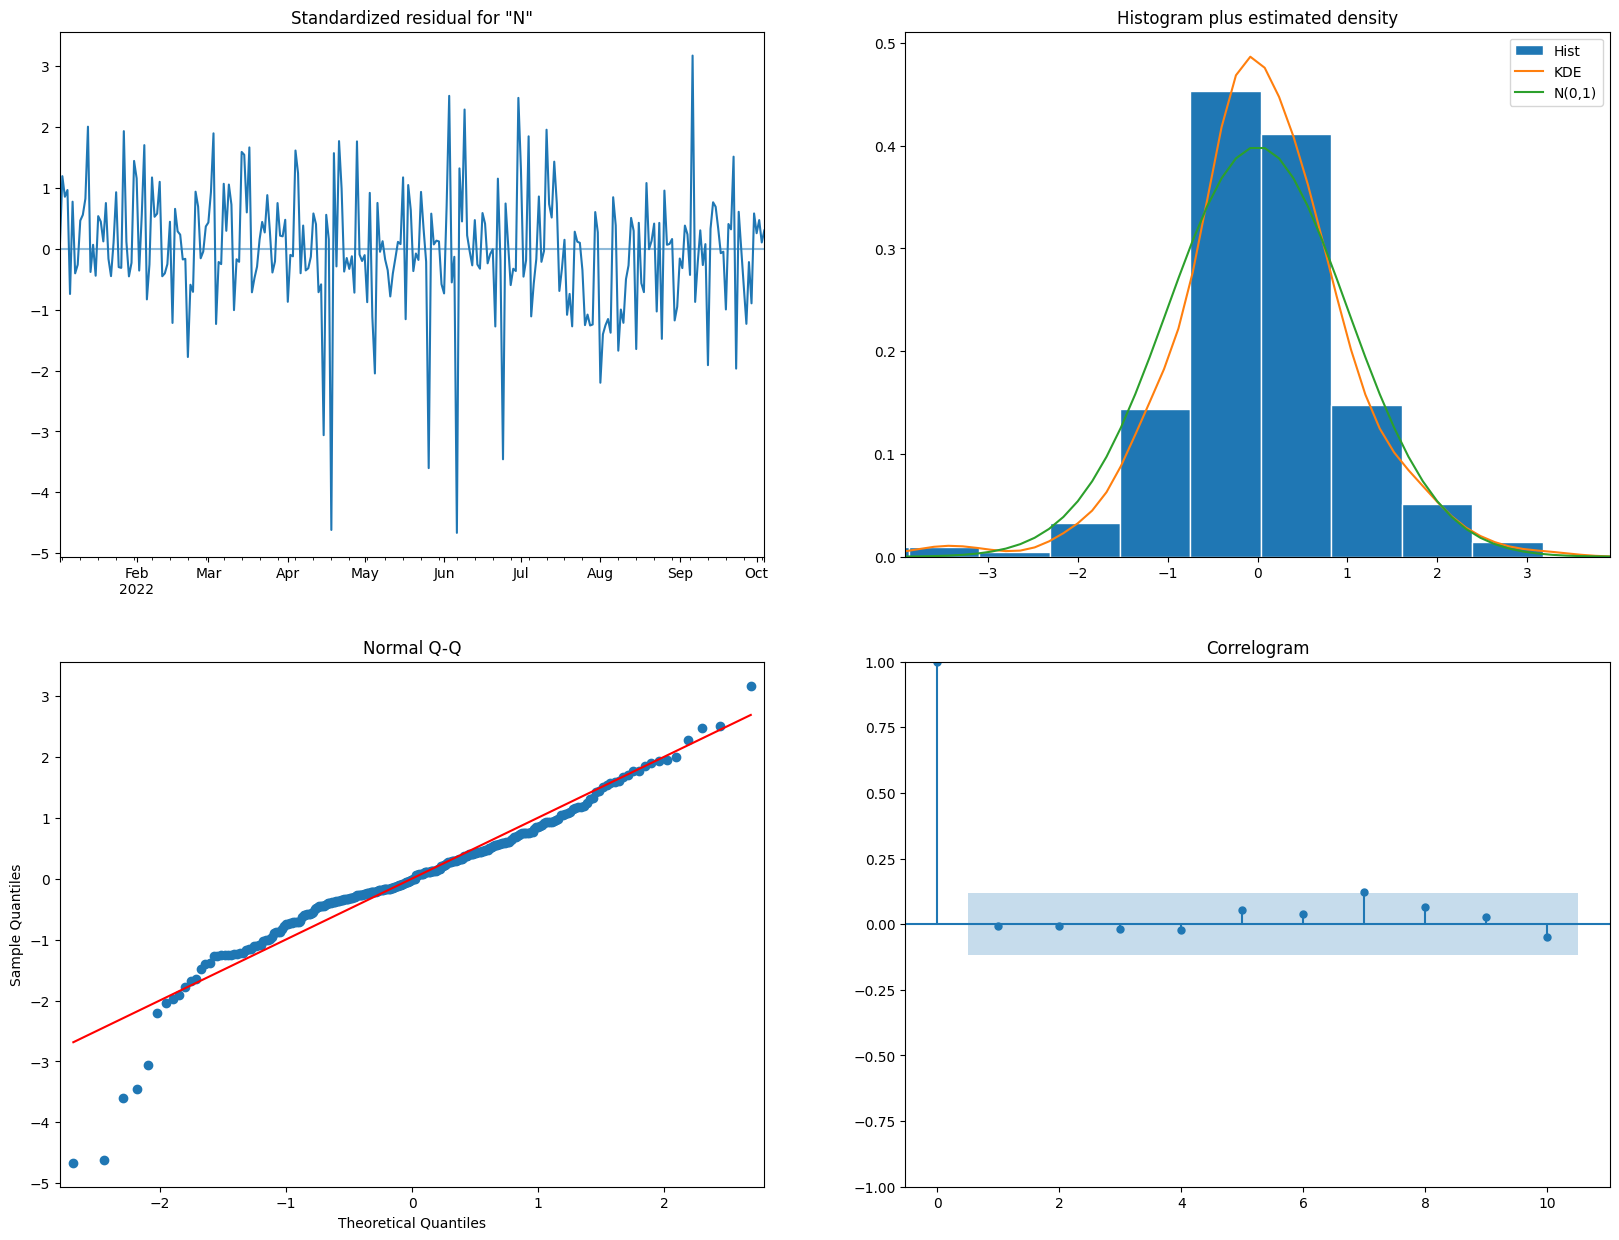

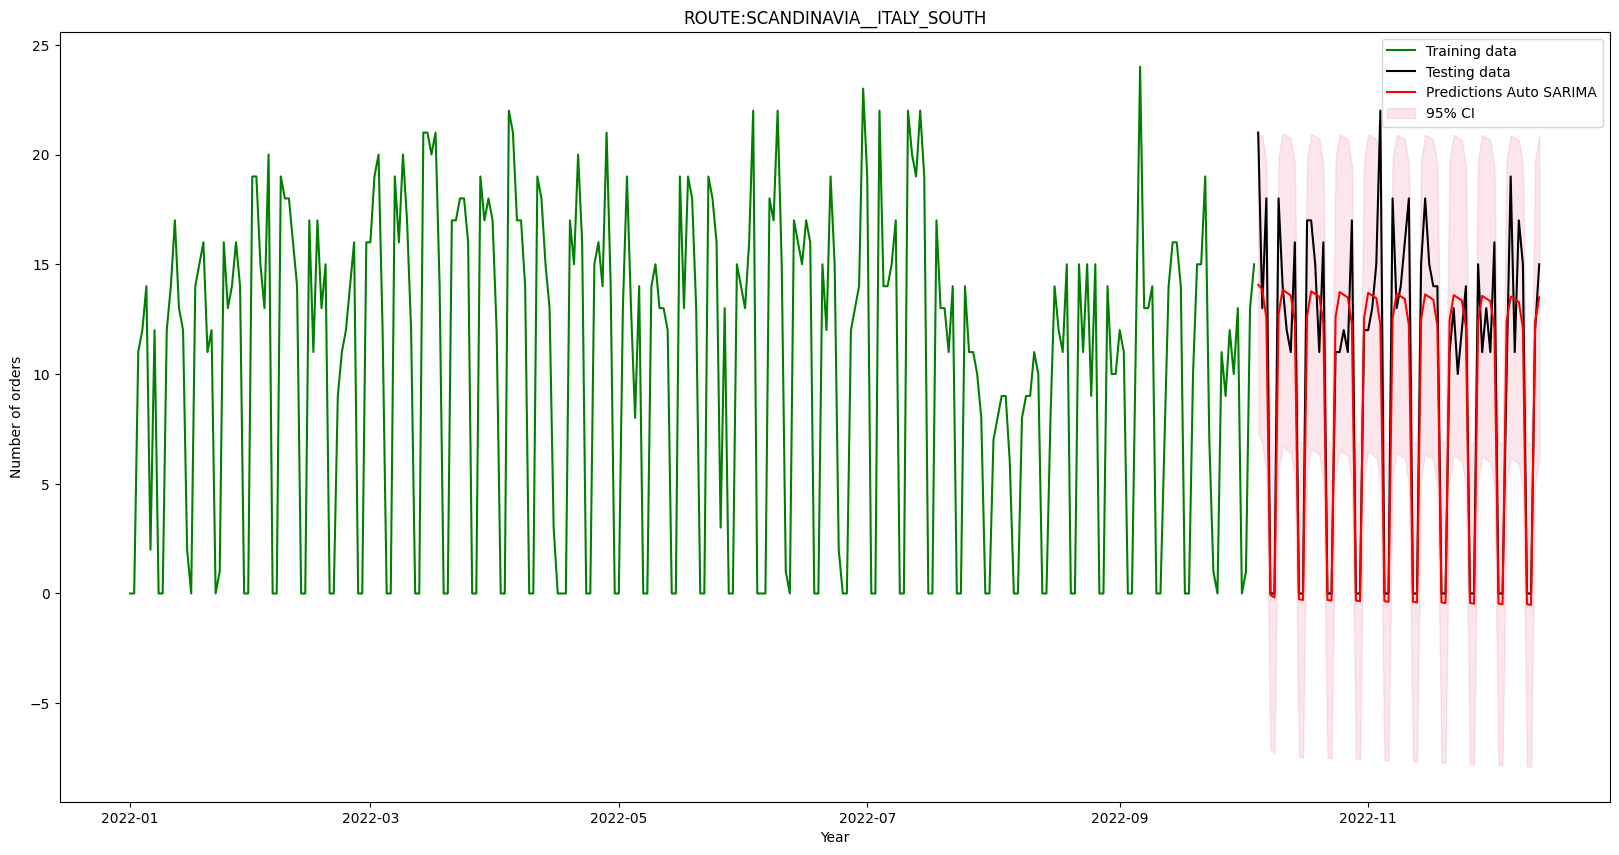


----------------------------------------------------------------------------------------

ROUTE: EAST_NORTH__EAST_NORTH


,NUMBER OF ACTUAL ORDERS
ORDER DATE,
2022-01-01,0
2022-01-02,0
2022-01-03,19
2022-01-04,33
2022-01-05,23
...,...
2022-12-09,18
2022-12-10,0
2022-12-11,0


TRAIN data:


,NUMBER OF ACTUAL ORDERS
ORDER DATE,
2022-01-01,0
2022-01-02,0
2022-01-03,19
2022-01-04,33
2022-01-05,23
...,...
2022-09-30,30
2022-10-01,1
2022-10-02,0


TEST data:


,NUMBER OF ACTUAL ORDERS
ORDER DATE,
2022-10-05,39
2022-10-06,26
2022-10-07,28
2022-10-08,1
2022-10-09,0
...,...
2022-12-09,18
2022-12-10,0
2022-12-11,0


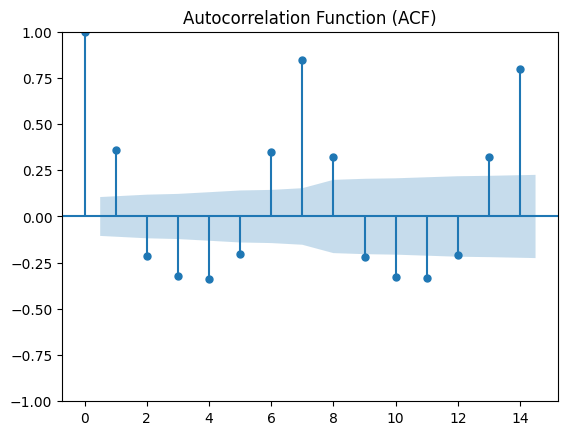

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=2017.148, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=2386.672, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=2051.018, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=2384.686, Time=0.00 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=2244.547, Time=0.10 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=2098.860, Time=0.08 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=2015.394, Time=0.72 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=2069.378, Time=0.29 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=2015.138, Time=0.67 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=2190.267, Time=0.17 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=1968.402, Time=0.53 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=2173.053, Time=0.75 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=1

c:\Users\elped\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\elped\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\elped\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                     
Dep. Variable:           NUMBER OF ACTUAL ORDERS   No. Observations:                  277
Model:             SARIMAX(5, 1, 1)x(1, 0, 1, 7)   Log Likelihood                -934.935
Date:                           Fri, 29 Nov 2024   AIC                           1887.870
Time:                                   19:58:34   BIC                           1920.453
Sample:                               01-01-2022   HQIC                          1900.945
                                    - 10-04-2022                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1637      0.103     -1.586      0.113      -0.366       0.039
ar.L2         -0.2974      0.090     -3.297

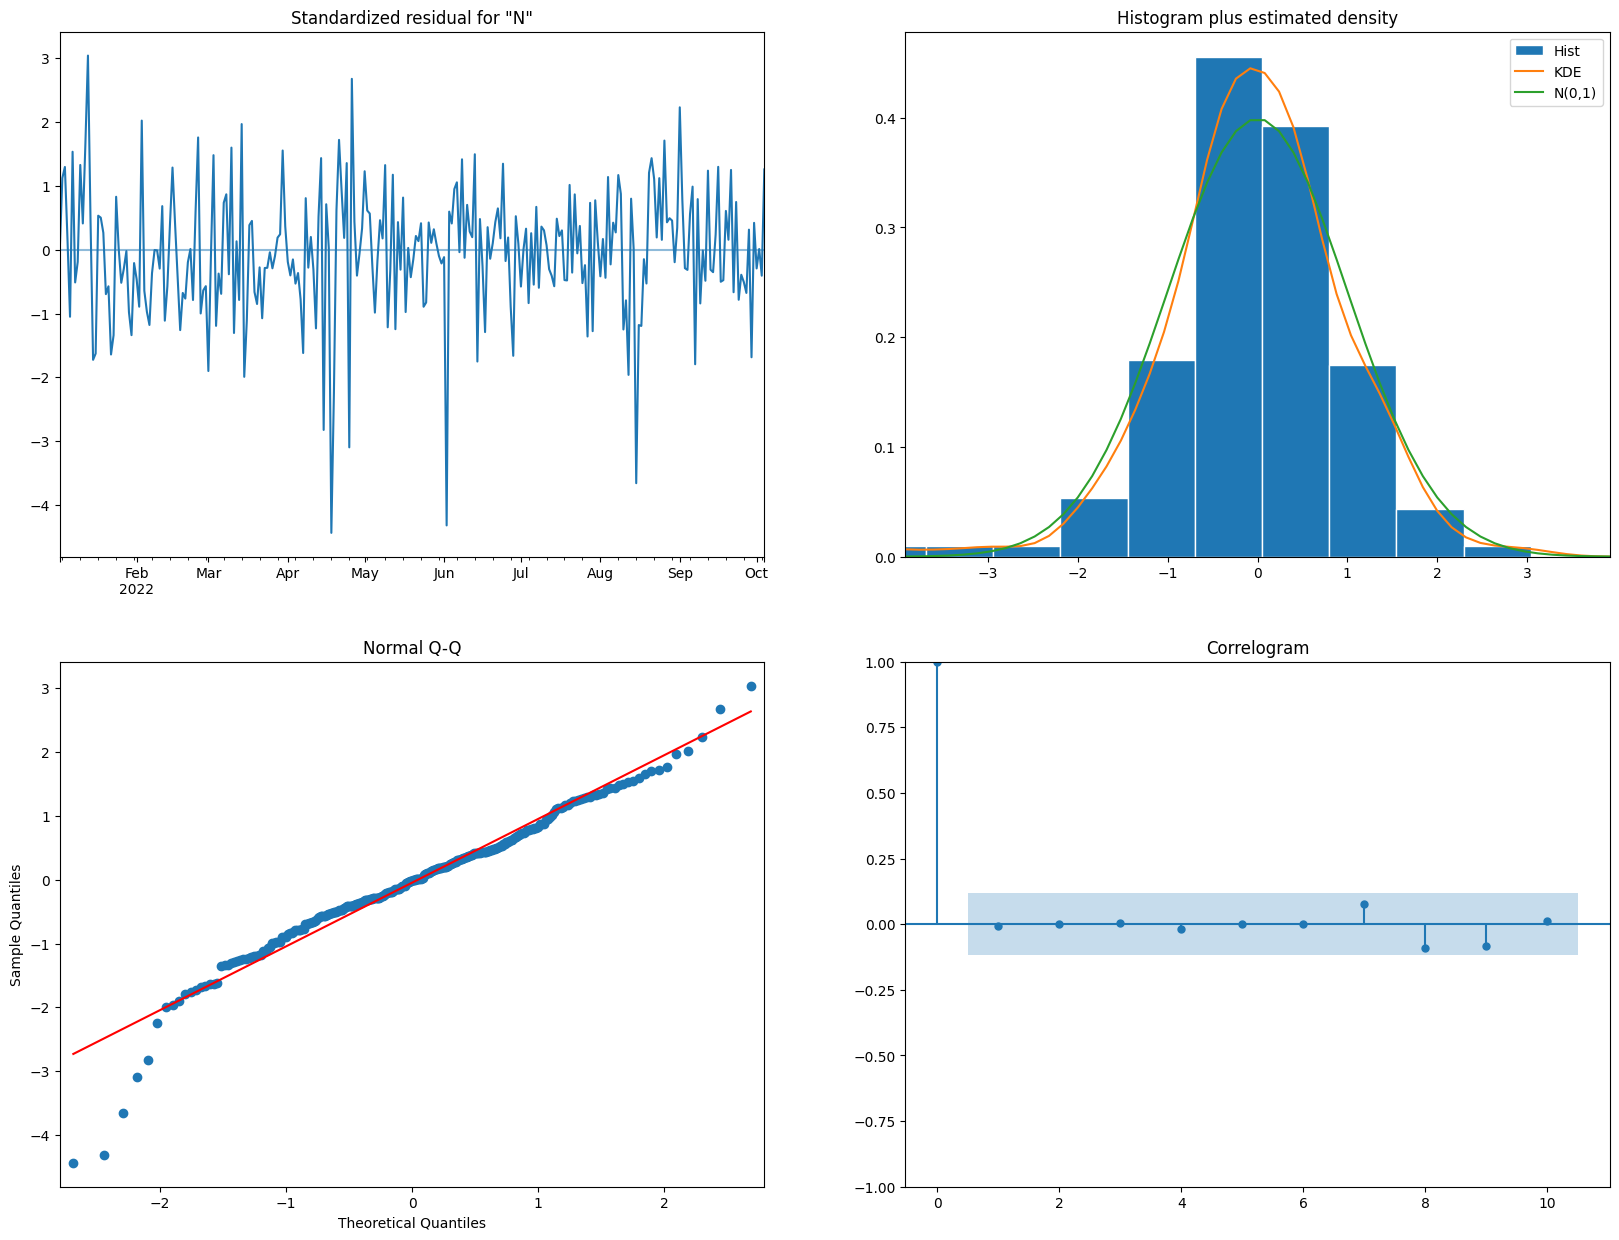

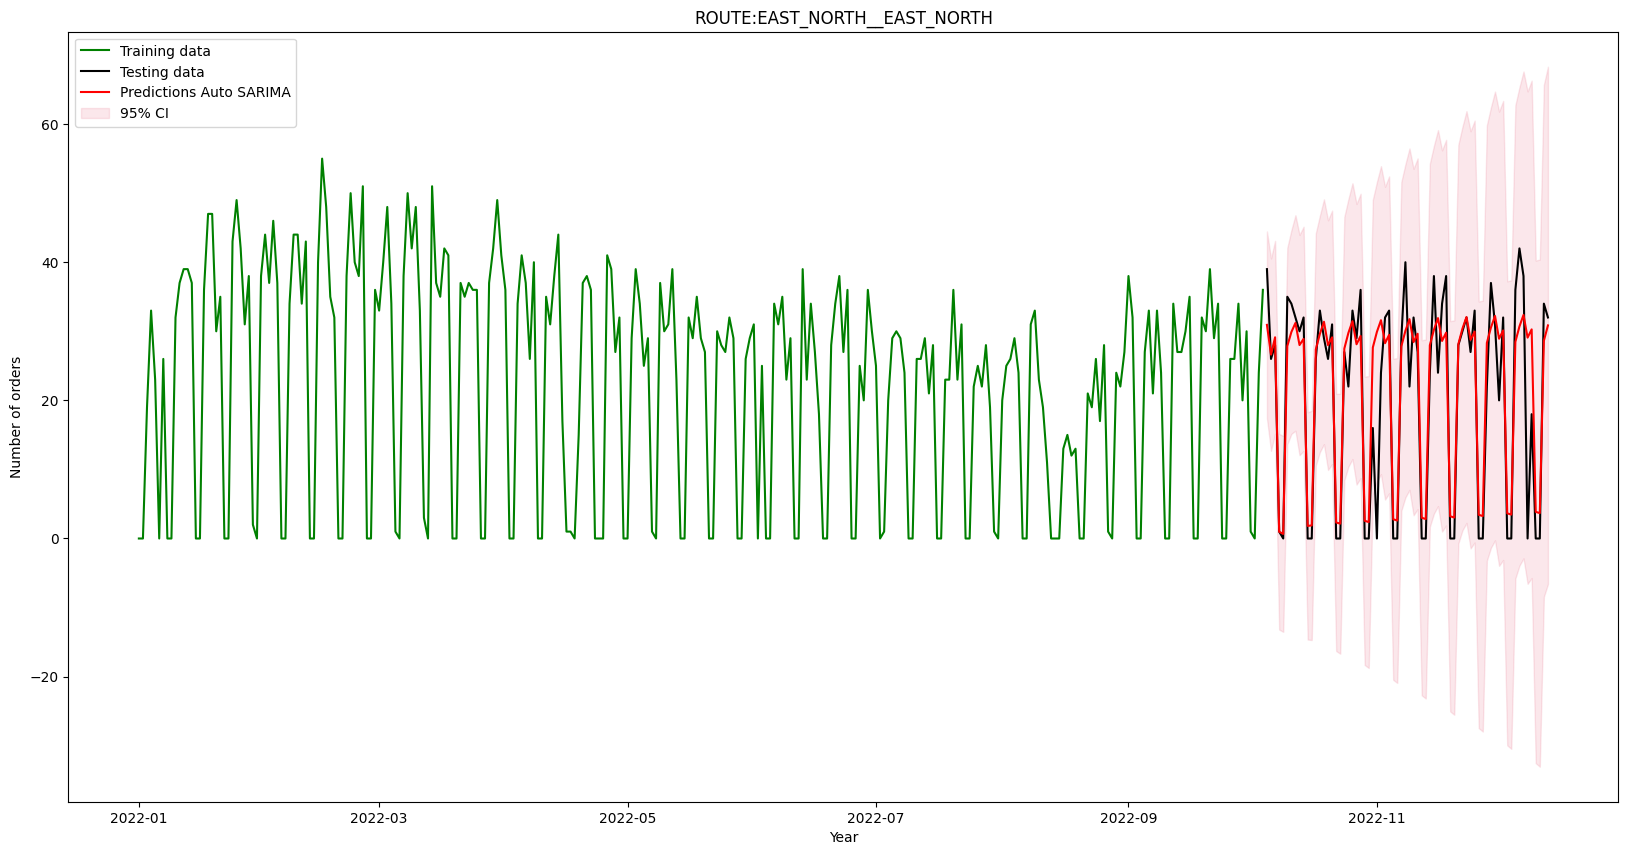


----------------------------------------------------------------------------------------

ROUTE: EAST_NORTH__ITALY_NORTH_EAST_CENTER


,NUMBER OF ACTUAL ORDERS
ORDER DATE,
2022-01-01,0
2022-01-02,4
2022-01-03,70
2022-01-04,78
2022-01-05,86
...,...
2022-12-09,63
2022-12-10,11
2022-12-11,7


TRAIN data:


,NUMBER OF ACTUAL ORDERS
ORDER DATE,
2022-01-01,0
2022-01-02,4
2022-01-03,70
2022-01-04,78
2022-01-05,86
...,...
2022-09-30,94
2022-10-01,8
2022-10-02,5


TEST data:


,NUMBER OF ACTUAL ORDERS
ORDER DATE,
2022-10-05,83
2022-10-06,73
2022-10-07,62
2022-10-08,7
2022-10-09,6
...,...
2022-12-09,63
2022-12-10,11
2022-12-11,7


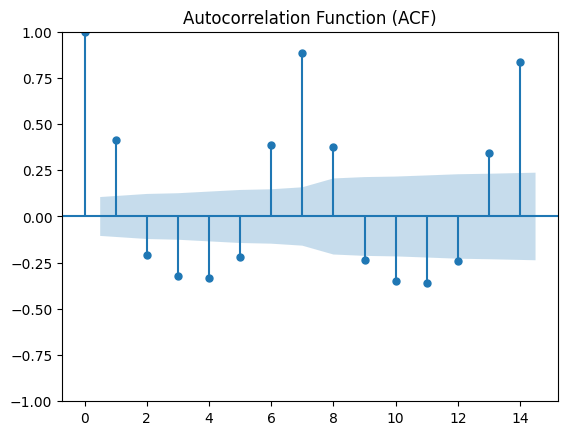

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=2391.767, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=2897.941, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=2425.512, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=2895.955, Time=0.01 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=2711.116, Time=0.20 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=2472.960, Time=0.30 sec
 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=1.64 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=inf, Time=0.85 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=2617.878, Time=0.28 sec
 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=2359.380, Time=0.42 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=2708.972, Time=0.14 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=0.75 s

c:\Users\elped\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\elped\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                       SARIMAX Results                                        
Dep. Variable:                NUMBER OF ACTUAL ORDERS   No. Observations:                  277
Model:             SARIMAX(3, 1, 0)x(1, 0, [1, 2], 7)   Log Likelihood               -1152.301
Date:                                Fri, 29 Nov 2024   AIC                           2318.602
Time:                                        19:59:16   BIC                           2343.945
Sample:                                    01-01-2022   HQIC                          2328.772
                                         - 10-04-2022                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5244      0.041    -12.774      0.000      -0.605      -0.444
ar.

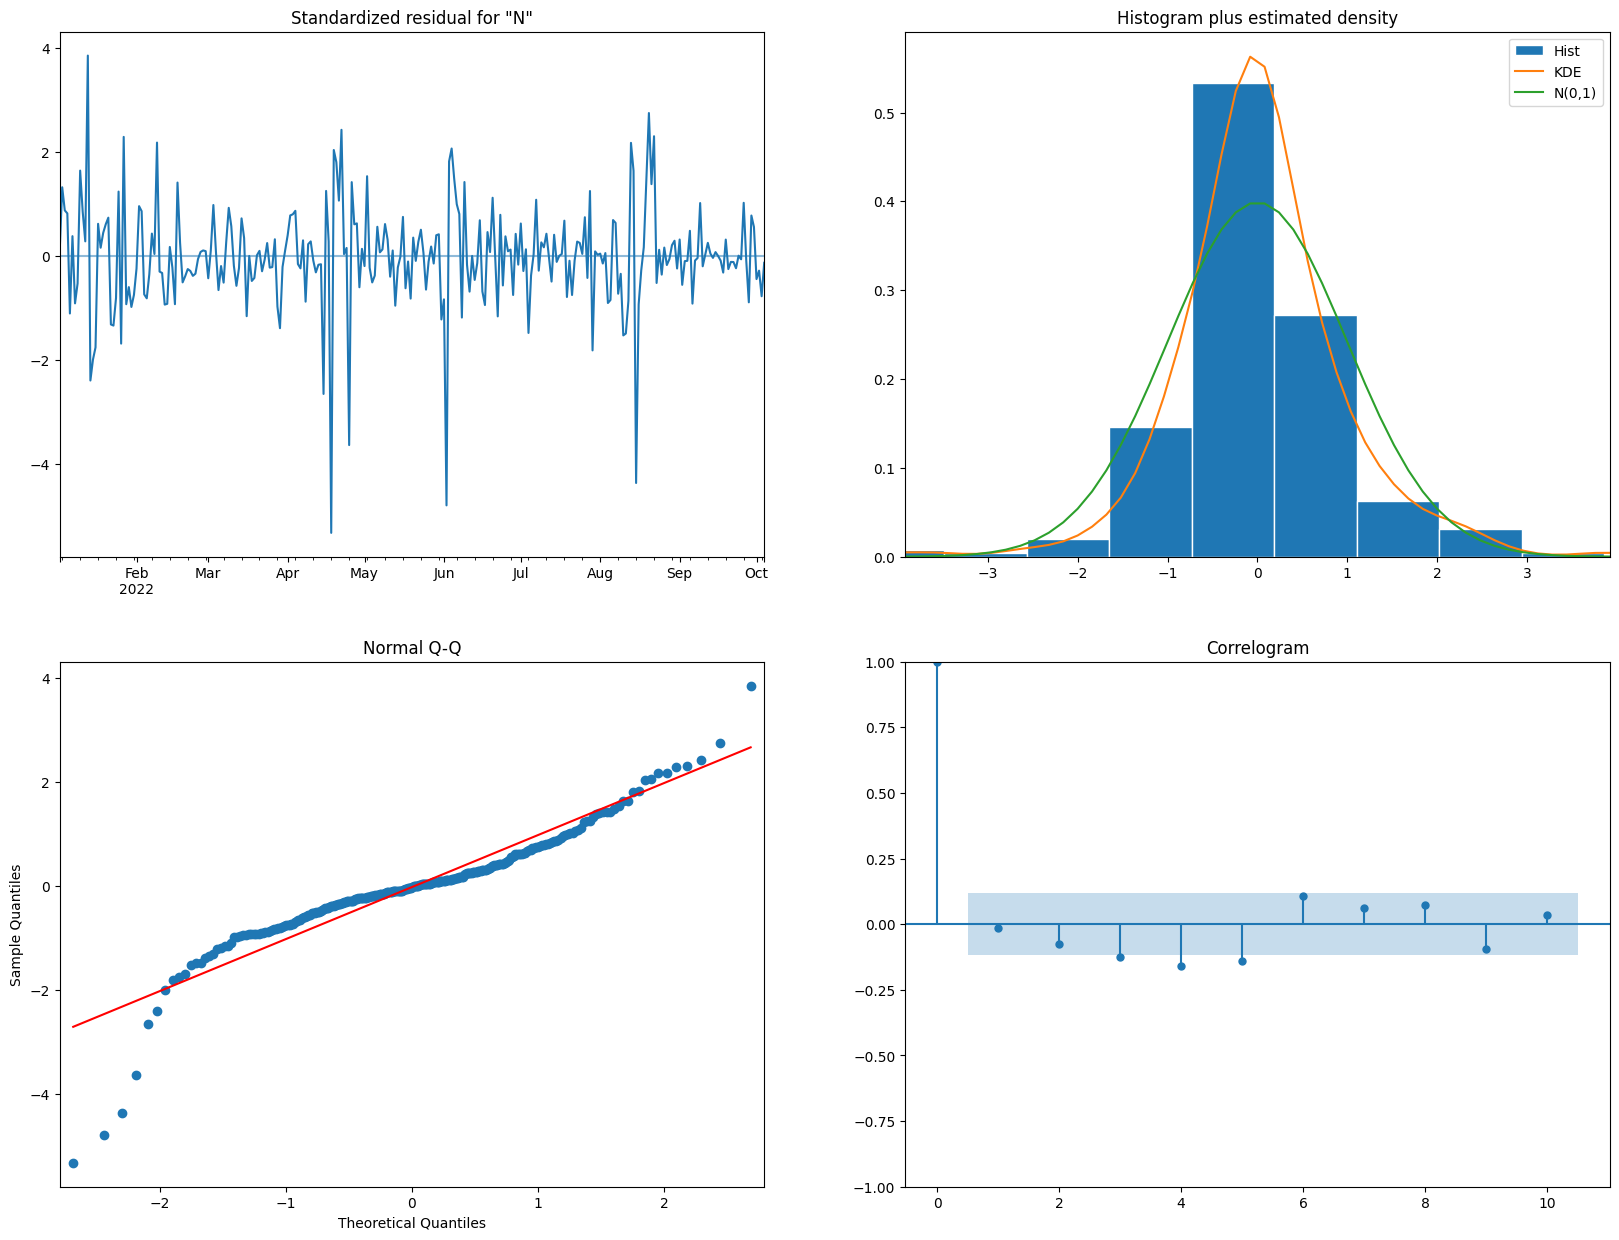

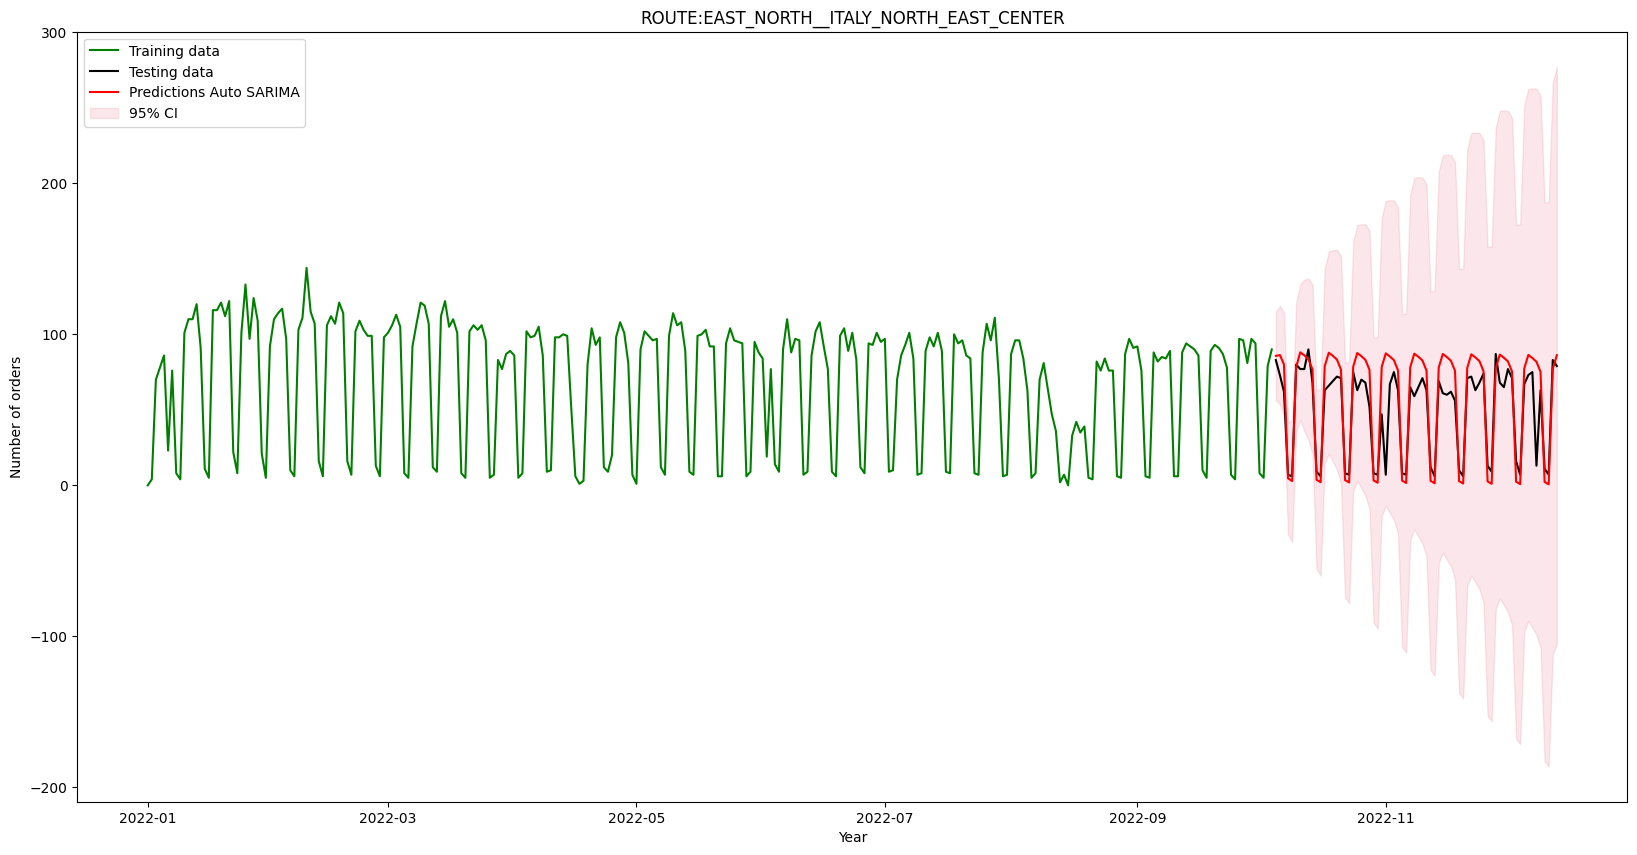


----------------------------------------------------------------------------------------



In [57]:
# open the file
data = open_file()
display(data)

#parse the date
data_parse = parse_date(data)
display(data_parse)

#create a loop to take only one root at time
for route in data_parse['ROUTE'].head(3):

    #create the pv_table aggregate from sum based on the date
    data_route = data_parse[data_parse['ROUTE'] == route]
    pv_route = pd.pivot_table(data_route, index = data_route.index, values='NUMBER OF ACTUAL ORDERS', aggfunc='sum')
    print('ROUTE:', route)
    display(pv_route)

    #split the data
    train, test = split_data(pv_route)
    print('TRAIN data:')
    display(train)
    print('TEST data:')
    display(test)

    #check if we want the autocorrelation function to check seasonality or tend (usefull to decide the parameter m -> seasonal pattern)
    acf(pv_route)

    #find the best parameter
    parameters = best_parameter(train)
    #take the parameters
    (p, d, q) = parameters.order
    (P, D, Q, S) =parameters.seasonal_order
    print(f"Best ARIMA order: {p, d, q}")
    print(f"Best Seasonal order: {P, D, Q, S}")

    #create the model
    SARIMAX_model = create_model(train, p, d, q, P, D, Q, S)
    print(SARIMAX_model.summary())
    SARIMAX_model.plot_diagnostics(figsize=(20, 15))
    #INSERIRE DURBIN WATSON????
    #print('Durbin watson: ', durbin_watson(SARIMAX_model.resid))
    #ljung_test = acorr_ljungbox(SARIMAX_model.resid, period=52)
    #ljung_test.head()

    #prediction
    prediction(SARIMAX_model, train, test, route)
    print('\n----------------------------------------------------------------------------------------\n')


    

ATTENZIONE: da quello che mi sembra di capire dai modelli, con m=7 le predizioni sembrano essere molto simili tra di loro, devo comprendere meglio i risultati dei modelli

potrebbe esserci un problema di overfitting?? (non credo)

però tra un giorno e l'altro non mi sembra di vedere molte differenze